In [14]:
## Clone our git repository
#! git clone https://github.com/keyonvafa/sequential-rationales

Cloning into 'sequential-rationales'...
remote: Enumerating objects: 3479, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 3479 (delta 49), reused 26 (delta 26), pack-reused 3405
Receiving objects: 100% (3479/3479), 16.34 MiB | 28.60 MiB/s, done.
Resolving deltas: 100% (758/758), done.


In [10]:
# ! pip install transformers
# ! pip install torch
# ! pip install ipywidgets
#! pip install seaborn
#! pip install huggingface

In [2]:
#! pip install --upgrade torch==1.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [6]:
#This solves the issue with ipwidgets when imporing hugginFace
# See: https://stackoverflow.com/questions/53247985/tqdm-4-28-1-in-jupyter-notebook-intprogress-not-found-please-update-jupyter-an/55554185
#! conda install -c conda-forge ipywidgets
#! jupyter nbextension enable --py widgetsnbextension

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<ipython-input-1-ac09909db896>:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import importlib
import torch
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib import colors
from transformers import AutoTokenizer, AutoModelWithLMHead

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.2) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
rationalization = importlib.import_module("sequential-rationales.huggingface.rationalization")
rationalize = rationalization.rationalize_lm
warnings.filterwarnings("ignore")

In [5]:
model = AutoModelWithLMHead.from_pretrained("keyonvafa/compatible-gpt2")
tokenizer = AutoTokenizer.from_pretrained("keyonvafa/compatible-gpt2")

Downloading:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [4]:
## Move model to GPU if available and trigger evaluation mode
if torch.cuda.is_available():
  model.cuda()
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
     

In [6]:
#@title Run this cell to create helper functions
def plot_rationales(rationales, rationalization_log):
  # Make a color map of fixed colors
  cmap = colors.ListedColormap(
    ['#eaeaf2', [0.01060815, 0.01808215, 0.10018654, 1.], 'firebrick'])
  bounds = [-0.5, 0.5, 1.5, 2.5]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  input_text = rationalization_log['input_text'].copy()
  rationalization_matrix = np.zeros((len(input_text), len(input_text)))
  for target_ind in range(len(rationales)):
    rationalization_matrix[target_ind + 1, rationales[target_ind]] = 1

  sns.set(rc={"grid.linewidth": 8})
  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(1, 1, 1)
  ax.imshow(rationalization_matrix, cmap=cmap, norm=norm, 
            interpolation='nearest')
  ax.set_xticks(np.arange(-0.5, len(input_text) - 0.5, 1))
  ax.set_yticks(np.arange(-0.5, len(input_text) - 0.5, 1))
  ax.set_xticks(range(len(input_text)), minor=True)
  ax.set_yticks(range(len(input_text)), minor=True)
  ax.set_xticklabels(['\n' + x for x in input_text], size=35, rotation=90, 
                    fontname="Liberation Sans")
  ax.set_yticklabels(['\n' + x for x in input_text], size=35, 
                    fontname="Liberation Sans")
  ax.grid(which='minor', color='w', linestyle='-', linewidth=0)



In [7]:
def generate_gpt2(input_string, max_length=16, do_sample=False):
  input_ids = tokenizer(
      input_string, return_tensors='pt')['input_ids'].to(model.device)
  print('input_ids',input_ids)
  input_ids = model.generate(
      input_ids=input_ids, max_length=max_length, do_sample=do_sample, 
      pad_token_id=50256)
  print("Generated sequence: {}".format(tokenizer.decode(input_ids[0])))
  return input_ids

In [8]:
# Define input_string to be the beginning of a sentence. We've included an example to get you started, but please feel free to replace this with your own example.
#input_string = "The Supreme Court on Tuesday"
input_string = "public class Bicycle { private int cadence;"

In [9]:
#*Generate* the remainder of the sentence using GPT-2.
input_ids = generate_gpt2(input_string, max_length=20)

input_ids tensor([[11377,  1398, 48444,  1391,  2839,   493, 20603,   594,    26]],
       device='cuda:0')
Generated sequence: public class Bicycle { private int cadence; private int speed; private int speed_min; private


Bad pipe message: %s [b'^\xb6\xbc\xa6\x15zP\x85w51\x0f\x03\xebY=\xfa+ _x\xa5\xfa\x07\x9c:\xc34\xb6\x83\tDM{r\xc8S\xfc\xfb\x86\xeb\xc7#$\x0csH0\x99\x0eD\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01']
Bad pipe message: %s [b'\xe4v\x91d}\x10\x14\xacS2\xa9\x19\xe6U6\x04Q\xb5 \x84d\xa8\x1eK\xd0\x8c\xa1DvR\xbc\x04\x8c\xc3*\x15\xb2X\xd1\x8a\xd6-\xf6\x9f\xd1]}M\xdbn\xb4\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\

In [34]:
input_ids

tensor([[11377,  1398, 48444,  1391,  2839,   493, 20603,   594,    26,  2839,
           493,  2866,    26,  2839,   493,  2866,    62,  1084,    26,  2839]],
       device='cuda:0')

In [35]:
#rationales are the token position in the matrix row 
rationales, rationalization_log = rationalize(model, 
                                              input_ids[0].to(model.device), 
                                              tokenizer, 
                                              verbose=False)

In [37]:
rationales

[[0],
 [1, 0],
 [2, 1, 0],
 [3, 2, 1, 0],
 [4, 3, 1, 0, 2],
 [5, 0, 2, 3, 4, 1],
 [6, 3],
 [7, 3, 5, 2, 6, 1],
 [8, 4, 3, 6, 7, 1, 2],
 [9, 5, 8, 4],
 [10, 8, 0, 2, 3],
 [11, 8, 10, 4],
 [12, 9, 4],
 [13, 10, 12, 5, 9],
 [14, 11, 9],
 [15, 5, 4, 8, 10, 11, 14],
 [16, 15, 7, 13, 5, 14, 11, 9, 0, 2],
 [17, 12, 14],
 [18, 9, 4]]

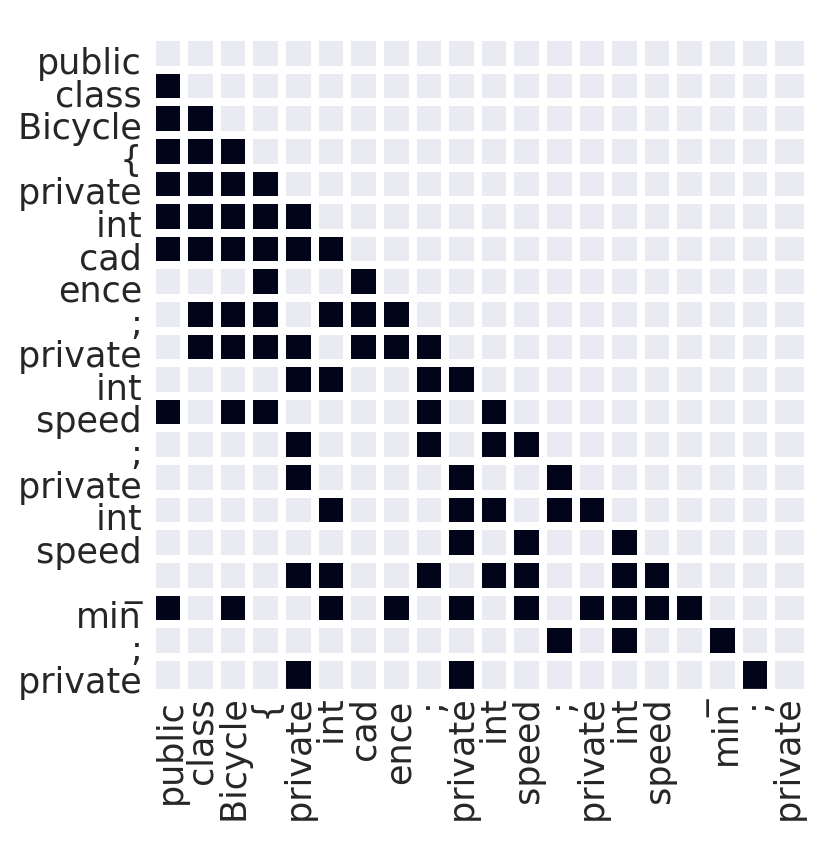

In [36]:
plot_rationales(rationales, rationalization_log)

In [1]:
from pathlib import Path


In [ ]:
def param_default():
    corpus = 'fm_fc_ms_ff' #<-- Scope
    data_path = Path('../athena-datasets/' + corpus + '/')
    data_path_raw = Path('../athena-datasets/' + corpus + '/raw/')
    tokenizer_path = Path('../tokenizer/')
    model_path = Path()
    return {
        'bpe_path' : tokenizer_path / 'universal_tokenizer/universal_tokenizer/roberta_aug_spaces',
        'eval_raw': [data_path_raw / 'eval/input.methods.txt',
                        data_path_raw / 'eval/output.tests.txt'],
        'test_raw': [data_path_raw / 'test/input.methods.txt', 
                        data_path_raw / 'test/output.tests.txt'],
        'train_raw': [data_path_raw / 'train/input.methods.txt', 
                        data_path_raw / 'train/output.tests.txt'],
        'data_labels' : ['eval_raw','test_raw','train_raw'],
        'output_pandas' : data_path / 'pandas/',
        'CHECKPOINT_DIR' : 
    }